In [50]:
from IPython.display import clear_output
!pip install imutils
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.inception_v3 import InceptionV3



In [51]:
pip install keras-resnet

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [53]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/T1 TEST/T2 VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 74 not upgraded.
mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/T1’: File exists
mkdir: cannot create directory ‘TEST/T2’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
.
├── TEST
│   ├── T1
│   └── T2
├── TEST_CROP
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── TRAIN_CROP
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
├── VAL_CROP
│   ├── NO
│   └── YES
└── preview

19 directories


In [54]:
IMG_PATH = '../input/wcebleedgen/WCEBleedGen/WCEBleedGen/bleeding/Images'
# split the data by train/val/test
IMG_NUM = len(os.listdir(IMG_PATH))
for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
    img = IMG_PATH + '/' + FILE_NAME
    if n < 0.8*IMG_NUM:
        shutil.copy(img, 'TRAIN/'+ 'YES' + '/' + FILE_NAME)
    else:
        shutil.copy(img, 'VAL/'+ 'YES' + '/' + FILE_NAME)

In [55]:
IMG_PATH = '../input/wcebleedgen/WCEBleedGen/WCEBleedGen/non-bleeding/images'
# split the data by train/val/test
IMG_NUM = len(os.listdir(IMG_PATH))
for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
    img = IMG_PATH + '/' + FILE_NAME
    if n < 0.8*IMG_NUM:
        shutil.copy(img, 'TRAIN/'+ 'NO' + '/' + FILE_NAME)
    else:
        shutil.copy(img, 'VAL/'+ 'NO' + '/' + FILE_NAME)

In [56]:
IMG_PATH = '../input/wcebleedgen/Test Dataset/Test Dataset 1'
IMG_NUM = len(os.listdir(IMG_PATH))
for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
    img = IMG_PATH + '/' + FILE_NAME
    shutil.copy(img, 'TEST'+ '/T2/' + FILE_NAME)

In [57]:
IMG_PATH = '../input/wcebleedgen/Test Dataset/Test Dataset 2'
IMG_NUM = len(os.listdir(IMG_PATH))
for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH)):
    img = IMG_PATH + '/' + FILE_NAME
    shutil.copy(img, 'TEST'+ '/T2/' + FILE_NAME)

3. Data Import and Preprocessing

In [58]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def load_test_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for file in sorted(os.listdir(dir_path)):
        if not file.startswith('.'):
            img = cv2.imread(dir_path + '/' + file)
            X.append(img)
            y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [59]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_test_data(TEST_DIR + 'T2', IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


2096 images loaded from TRAIN/ directory.
564 images loaded from TEST/T2 directory.


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

522 images loaded from VAL/ directory.


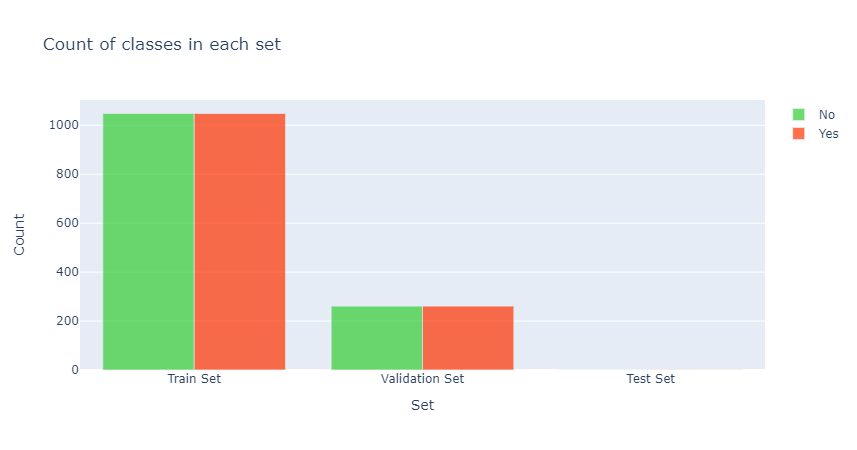

In [60]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [61]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n-1]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,2))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            img[0]=cv2.cvtColor(img[0],cv2.COLOR_BGR2RGB)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('{}'.format(labels_dict[index]))
        plt.show()

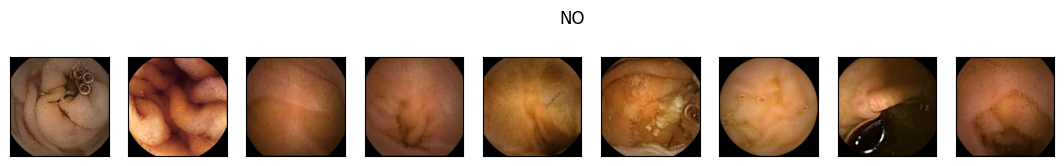

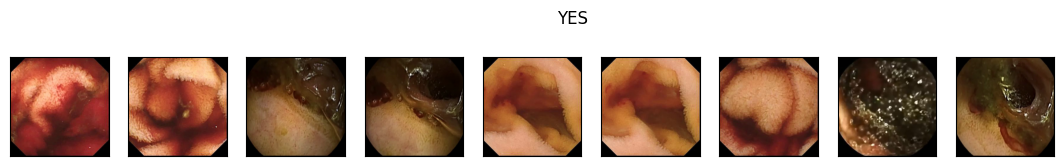

In [62]:
plot_samples(X_train, y_train, labels, 10)

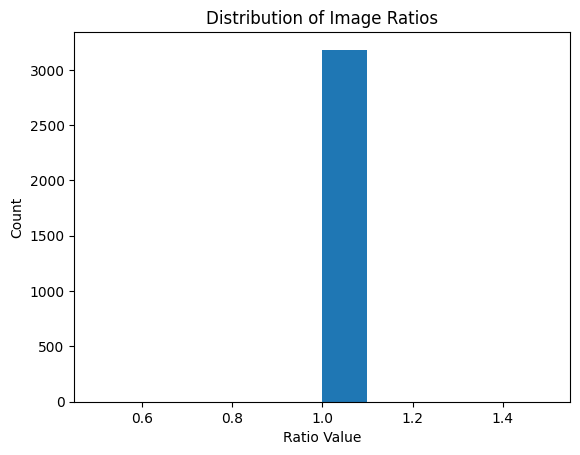

In [63]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [64]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [65]:
img = cv2.imread('../input/wcebleedgen/WCEBleedGen/WCEBleedGen/non-bleeding/images/img- (20).png')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

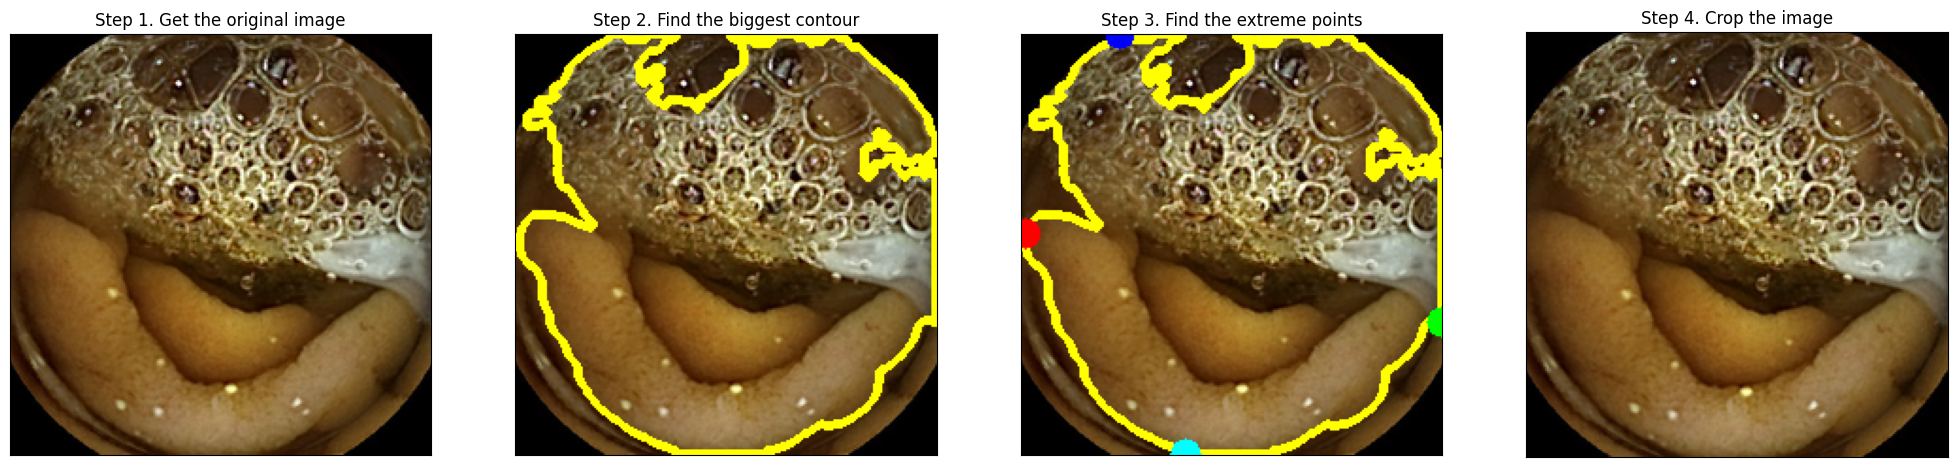

In [66]:
plt.figure(figsize=(25,10))
plt.subplot(141)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
img_cnt=cv2.cvtColor(img_cnt,cv2.COLOR_BGR2RGB)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
img_pnt=cv2.cvtColor(img_pnt,cv2.COLOR_BGR2RGB)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
new_img=cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [67]:
# apply this for each set
# X_train_crop = crop_imgs(set_name=X_train)
# X_val_crop = crop_imgs(set_name=X_val)
# X_test_crop = crop_imgs(set_name=X_test)

X_train_crop = X_train
X_val_crop = X_val
X_test_crop = X_test

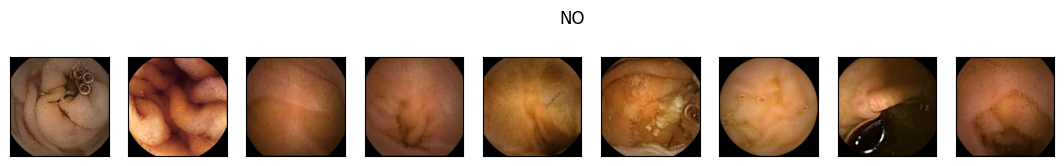

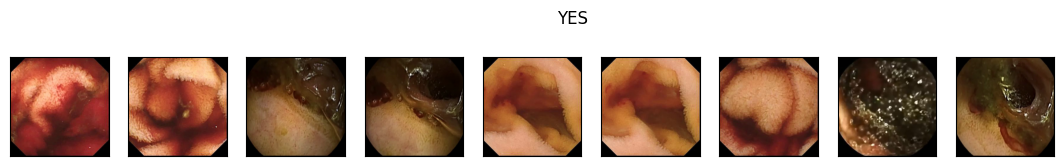

In [68]:
plot_samples(X_train_crop, y_train, labels, 10)

In [69]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [70]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [71]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [72]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

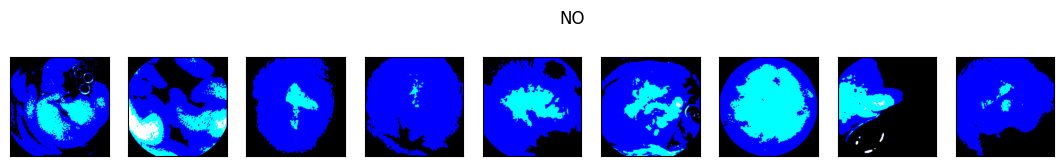

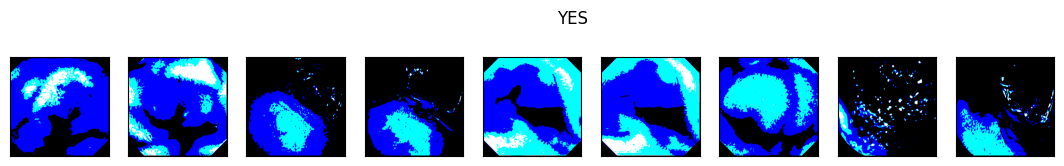

In [73]:
 plot_samples(X_train_prep, y_train, labels, 10)

DATA AUGMENTATION

In [74]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [76]:
# os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

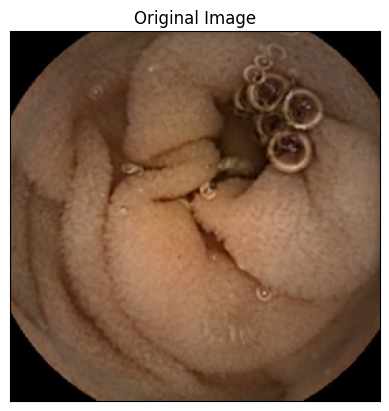

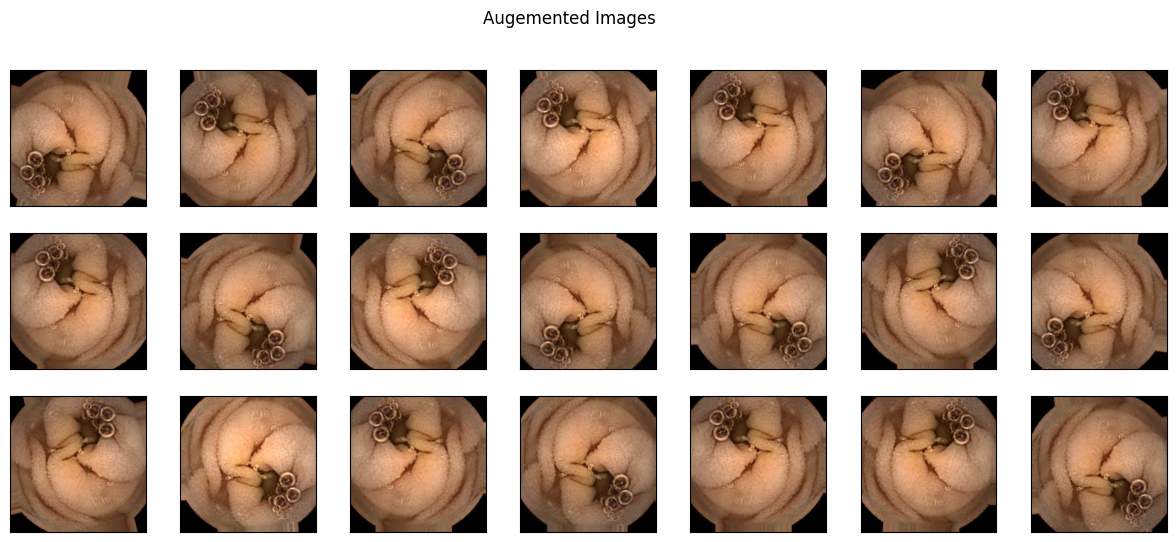

In [77]:
X_train_crop[0] = cv2.cvtColor(X_train_crop[0], cv2.COLOR_BGR2RGB)
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [78]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2096 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


In [79]:
# load base model
ResNet50_weight_path = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50_x = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [80]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input


In [81]:
import os
import sys
import random
import warnings
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers.merge import concatenate
from skimage.morphology import label


ModuleNotFoundError: No module named 'keras.layers.merge'

In [82]:


NUM_CLASSES = 1

resnet50 = Sequential()
resnet50.add(resnet50_x)
resnet50.add(layers.Dropout(0.3))
resnet50.add(layers.Flatten())
resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

resnet50.layers[0].trainable = False

resnet50.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
resnet50.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_5 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [83]:
import time

start = time.time()

resnet50_history = resnet50.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

/tmp/ipykernel_28/3435472635.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20


2023-10-09 17:50:03.755183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 31s 554ms/step - loss: 0.5926 - accuracy: 0.8388 - val_loss: 0.1602 - val_accuracy: 0.9354
Epoch 2/20
50/50 [==============================] - 26s 519ms/step - loss: 0.3185 - accuracy: 0.9129 - val_loss: 0.1048 - val_accuracy: 0.9646
Epoch 3/20
50/50 [==============================] - 25s 489ms/step - loss: 0.1682 - accuracy: 0.9495 - val_loss: 0.0866 - val_accuracy: 0.9646
Epoch 4/20
50/50 [==============================] - 26s 526ms/step - loss: 0.2073 - accuracy: 0.9432 - val_loss: 0.0932 - val_accuracy: 0.9750
Epoch 5/20
50/50 [==============================] - 25s 502ms/step - loss: 0.1821 - accuracy: 0.9463 - val_loss: 0.0521 - val_accuracy: 0.9854
Epoch 6/20
50/50 [==============================] - 26s 516ms/step - loss: 0.1557 - accuracy: 0.9621 - val_loss: 0.1481 - val_accuracy: 0.9542
Epoch 7/20
50/50 [==============================] - 26s 519ms/step - loss: 0.1549 - accuracy: 0.9577 - val_loss: 0.0434 - val_accuracy: 0.9854
Epoch 8/20

In [84]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

In [85]:
predictions_r50 = resnet50.predict(X_val_prep)
predictions_r50 = [1 if x>0.5 else 0 for x in predictions_r50]


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions_r50)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions_r50)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions_r50)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions_r50)
print('F1 score: %f' % f1)

17/17 [==============================] - 2s 94ms/step
Accuracy: 0.932950
Precision: 0.941406
Recall: 0.923372
F1 score: 0.932302


  4%|▍         | 21/522 [00:00<00:08, 61.12it/s]


ValueError: num must be an integer with 1 <= num <= 21, not 22

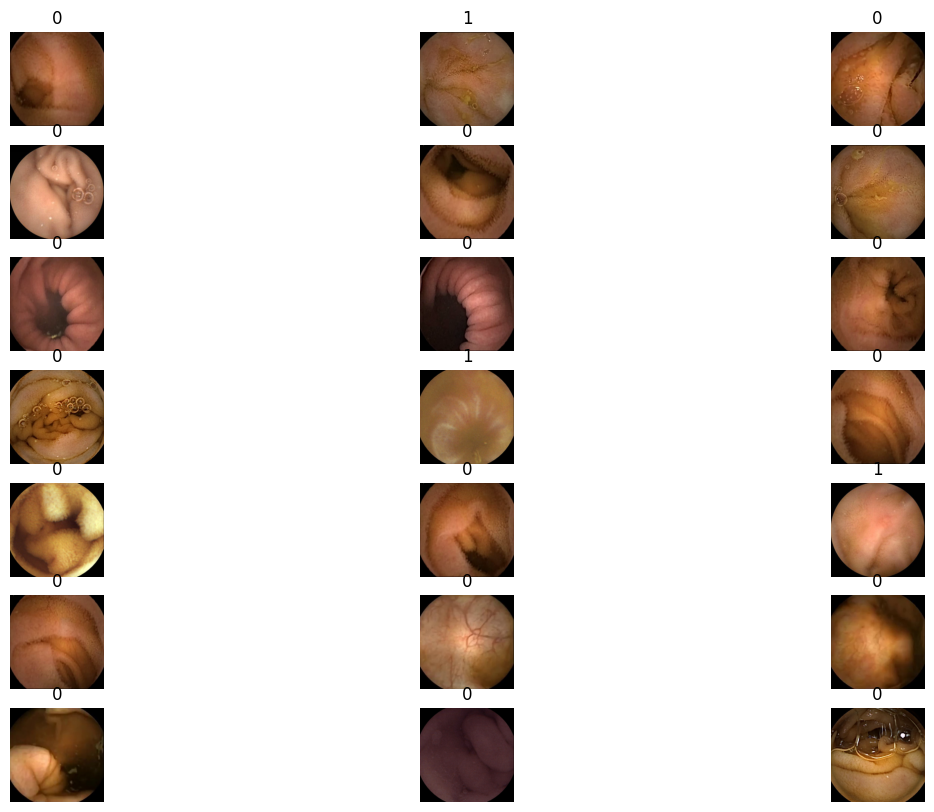

In [101]:
fig = plt.figure(figsize=(15,10))
k = 0
i = 0
for labels in tqdm(predictions_r50):
    fig.add_subplot(7,3,k+1)
    X_val_crop[i]=cv2.cvtColor(X_val_crop[i],cv2.COLOR_BGR2RGB)
    plt.imshow(X_val_crop[i])
    plt.title(labels)
    plt.axis('off')
    i += 1
    k+=1
plt.show()

In [ ]:
kappa = cohen_kappa_score(y_val, predictions_r50)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions_r50)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_val, predictions_r50)
print(matrix)

In [ ]:
import matplotlib.pyplot as plt
from numpy import expand_dims

In [ ]:
plt.figure(figsize=(12,12))
# plot loss during training
plt.subplot(211)
plt.title('Resnet50 Loss')
plt.plot(resnet50_history.history['loss'], label='train')
plt.plot(resnet50_history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Resnet50 Accuracy')
plt.plot(resnet50_history.history['acc'], label='train')
plt.plot(resnet50_history.history['val_acc'], label='Validation')
plt.legend()
plt.show()